In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 25.2 MB/s 
     |████████████████████████████████| 77 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=436596 sha256=a52869b8b99f043fd43aa29fa358280614d7197bcee66e635b0f36e3e560798f
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4ad90c9e699c56d
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:44tcmalloc: large alloc 1147494400 bytes == 0x3a186000 @  0x7f98f1c58615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x5

In [2]:
# Import the game
import gym_super_mario_bros # import to make an environment
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation # wrapper that converts a color observation to grayscale
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [3]:
enviro = gym_super_mario_bros.make('SuperMarioBros2-v0')
enviro = JoypadSpace(enviro, SIMPLE_MOVEMENT)

In [4]:
# Create the base environment
enviro = gym_super_mario_bros.make('SuperMarioBros2-v0')
enviro = JoypadSpace(enviro, SIMPLE_MOVEMENT)
enviro = GrayScaleObservation(enviro, keep_dim=True)
enviro = DummyVecEnv([lambda: enviro])
enviro = VecFrameStack(enviro, 4, channels_order='last')

In [5]:
state = enviro.reset()

In [6]:
state, reward, done, info = enviro.step([5])

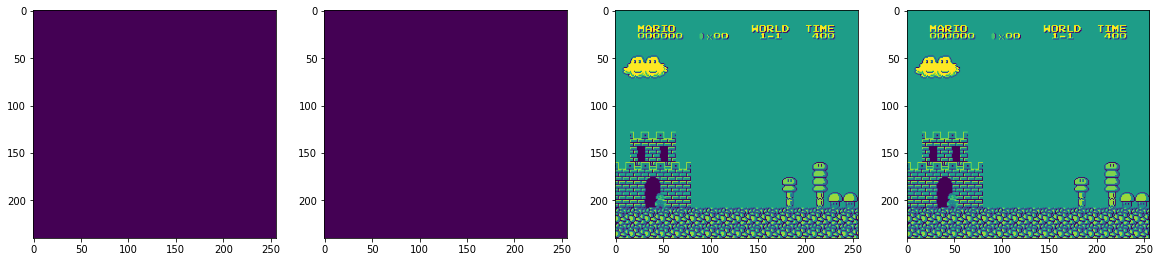

In [7]:
# Visualizing Map
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [8]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [21]:
CHECKPOINT_DIR = 'train'
LOG_DIR = 'logs'

In [30]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=30000, save_path=CHECKPOINT_DIR)

In [31]:
# AI model
model = PPO('CnnPolicy', enviro, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [32]:
# Training the model 
model.learn(total_timesteps=1600, callback=callback)

Logging to logs/PPO_3
----------------------------
| time/              |     |
|    fps             | 174 |
|    iterations      | 1   |
|    time_elapsed    | 2   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 97            |
|    iterations           | 2             |
|    time_elapsed         | 10            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.9912102e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.00715       |
|    learning_rate        | 1e-06         |
|    loss                 | 93.4          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000417     |
|    value_loss           | 287           |
---------------------------

In [33]:
# Model Save
model.save('MARIO_CAMPEROSO')

In [34]:
# Model load
model = PPO.load('/content/MARIO_CAMPEROSO.zip')

In [35]:
state = enviro.reset()

In [36]:
# Recording Agent
from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros2-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(5000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

Exception ignored in: <function Monitor.__del__ at 0x7f789539c950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 289, in __del__
  File "/usr/local/lib/python3.7/dist-packages/gym/wrappers/monitor.py", line 178, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/gym/core.py", line 298, in close
  File "/usr/local/lib/python3.7/dist-packages/nes_py/nes_env.py", line 346, in close
ValueError: env has already been closed.
/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [37]:
# Watching Agent
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))